## 介绍



## 导入数据

第一步需要引入必要的包

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import jieba

%matplotlib inline

ImportError: No module named jieba

导入数据文件 `items.csv`, 并命名为`jobs`

In [ ]:
jobs = pd.read_csv('items.csv'); jobs.head(1)

## 处理数据

按顺序保留如下列，存入新的变量`n_jobs`中：

```
['job_id', 'job_title','comp_name','salary','salary_min','salary_max','experience','job_desp','comp_id']

```

In [ ]:
n_jobs = jobs[['job_id', 'job_title','comp_name','salary','salary_min','salary_max','experience','job_desp','comp_id']]

接下来：
- 将`experience`需要的工作年限变为数值型
- 分析下工作年限需要的分布
- 分析下工作年限跟薪水之间的关系
- 分析下工作职责描述中提到最多的技能项

In [ ]:
def changeExp(x):
    pt_s = '(\d+)年以上经验'
    pt = re.compile(pt_s)
    if pt.match(x):
        gg = pt.search(x)
        return int(gg.group(1))
    elif x == '经验不限':
        return 0
    else:
        x = Null

n_jobs['experience'] = n_jobs['experience'].apply(changeExp);
n_jobs = n_jobs.set_index('job_id')
n_jobs.head(1)

工作年限的需求分布

Text(0,0.5,u'Count')

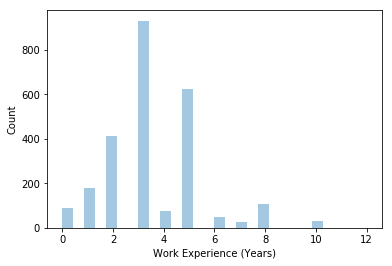

In [86]:
ax = sns.distplot(n_jobs['experience'], norm_hist=False, kde=False)
ax.set_xlabel('Work Experience (Years)')
ax.set_ylabel(u'Count')


工作年限跟薪水的关系

In [93]:
salary_exp = n_jobs.groupby('experience').mean().reset_index()

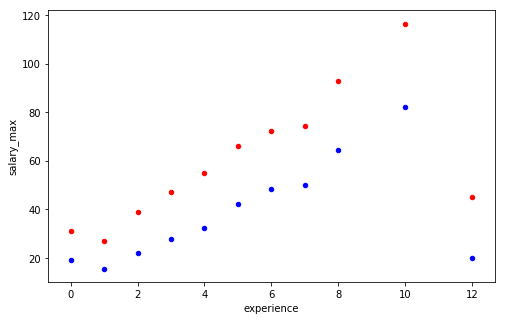

In [107]:
ax = salary_exp.plot( kind='scatter',x='experience',   y='salary_min', color='b', figsize=(8,5) )
salary_exp.plot(kind='scatter',x='experience',  y='salary_max', color='r', ax = ax)

plt.show()
